# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [1]:
# Importer resten av pakkene du trenger her:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

In [3]:
#TODO: visualiser y_train og y_test i et histogram

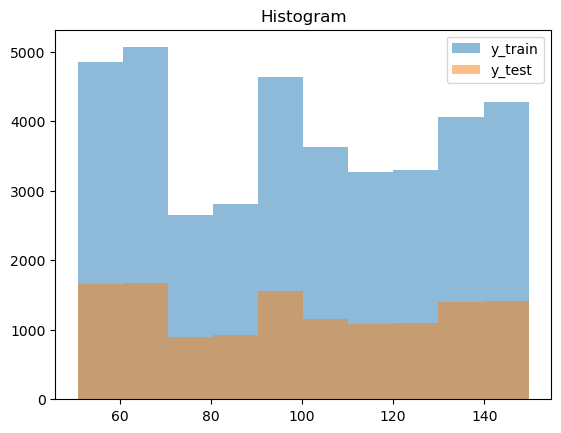

In [3]:
plt.hist(y_train, bins=10, alpha=0.5, label='y_train')
plt.hist(y_test, bins=10, alpha=0.5, label='y_test')

plt.title('Histogram')
plt.legend()
plt.show()

## Man ser ut i fra historgrammet at trenings dataen og test dataen er uniformt distribuert 

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    #TODO: Fullfør koden
    ...

In [4]:
def korrelasjonsmatrise(X, y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp

    correlation_matrix = X_temp.corr()

    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(correlation_matrix.columns)), rotation=45)
    plt.yticks(range(len(correlation_matrix.columns)))
    plt.title('Korrelasjonsmatrise')
    plt.show()



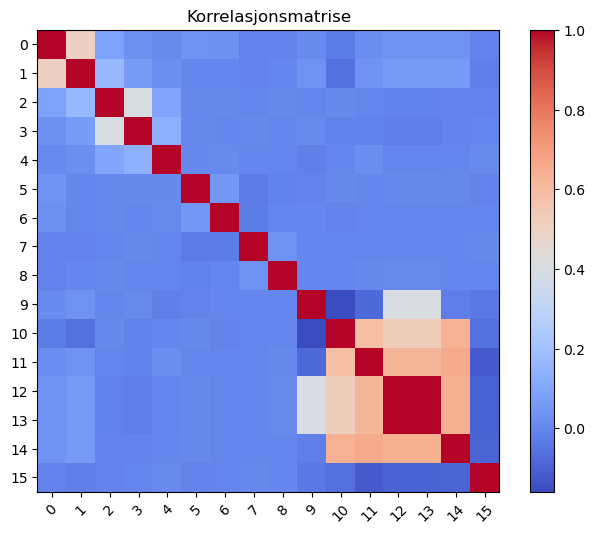

In [5]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**
Det ser ut til ut i fra matrisen at det ikke er noen særlig korrelasjon med target variablen.

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [7]:
#TODO: Utfør hyperparametersøk for en modell

In [18]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

param_grid_lin_reg = {
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'n_jobs': [None, 1, 4, 5],
    'positive': [False, True],
}

linreg = LinearRegression()

search_lr = GridSearchCV(estimator=linreg, param_grid=param_grid_lin_reg, cv=rkf, scoring='neg_mean_squared_error')

search_lr.fit(X_train, y_train)

best_model = search_lr.best_estimator_
best_params = search_lr.best_params_

ValueError: Invalid parameter 'normalize' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].

In [15]:
print("Best Model Parameters:", best_params)
best_score = search_lr.best_score_
print("Best Score (neg_mean_squared_error):", best_score)

Best Model Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Best Score (neg_mean_squared_error): -886.4313068071665


Konfigurasjonen som vil gi best ytelse på modelen vil være : copy_X: True, fit_intercept: True, n_jobs: None, positive: False
En negativ mean squared error (MSE) på ca -886.4 vil si at modellen har en god prediksjons evne.

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [7]:
#TODO: Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


best_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, positive=False)

k_fold = 10 
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=k_fold, scoring='neg_mean_squared_error')

mae_scores = []
mse_scores = []

for train_idx, test_idx in rkf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    best_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = best_model.predict(X_test_cv)
    
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    
    mae_scores.append(mae)
    mse_scores.append(mse)

average_cv_score = cross_val_scores.mean()

print(f'Average, with K >= {k_fold}: {average_cv_score}')

for i, (mae, mse) in enumerate(zip(mae_scores, mse_scores), start=1):
    print(f'Round {i} - MAE: {mae}, MSE: {mse}')


C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inst

C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inst

C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inst

Average, with K >= 10: -886.4458779153531
Round 1 - MAE: 25.76252873816289, MSE: 885.5156228396488
Round 2 - MAE: 25.78012725952072, MSE: 890.1347304450612
Round 3 - MAE: 25.619435908975163, MSE: 885.170073032687
Round 4 - MAE: 25.68172619985326, MSE: 891.0414978707053
Round 5 - MAE: 25.59150650067932, MSE: 880.2543218299122
Round 6 - MAE: 25.80593421539887, MSE: 894.925167525179
Round 7 - MAE: 25.73980786057312, MSE: 889.1806883985349
Round 8 - MAE: 25.653064760440135, MSE: 885.1573854804219
Round 9 - MAE: 25.622962521470658, MSE: 880.6151322887317
Round 10 - MAE: 25.61672770707364, MSE: 882.0678223037063
Round 11 - MAE: 25.636211254945724, MSE: 884.6651133810783
Round 12 - MAE: 25.89281392983773, MSE: 895.5259807111312
Round 13 - MAE: 25.830309576270768, MSE: 895.6633398144241
Round 14 - MAE: 25.40445265883812, MSE: 867.8401082940704
Round 15 - MAE: 25.683627570493286, MSE: 888.7126178922039


C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inst

In [8]:
#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
# gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

In [17]:
import numpy as np
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'Mean MAE: {mean_mae}, Std MAE: {std_mae}')
print(f'Mean MSE: {mean_mse}, Std MSE: {std_mse}')

mean_mae_prosent = (mean_mae / np.mean(y_train)) * 100
mean_mse_prosent = (mean_mse / np.mean(y_train)) * 100

print("MAE som prosentandel av gjennomsnittsprisen:", mean_mae_prosent, "%")
print("MSE som prosentandel av gjennomsnittsprisen:", mean_mse_prosent, "%")

Mean MAE: 25.688082444168902, Std MAE: 0.11561917936146522
Mean MSE: 886.4313068071665, Std MSE: 6.984024988405145
MAE som prosentandel av gjennomsnittsprisen: 25.859786674892053 %
MSE som prosentandel av gjennomsnittsprisen: 892.3563892244721 %


**Svar:**

Lavere prosentandeler indikerer mindre feil i forhold til gjennomsnittsprisen, mens høyere prosent  andeler indikerer større feil. En prosent på 892 indikerer at modellen har en gjennomsnittelig kvadrat feil på 892% av gjennomsnittsprisen. Noe som gir tegn på at modellen ikke gir gode nok prognoser.

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)


In [9]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, positive=False)

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

MSE: 893.587192935745
MAE: 25.79337662131177
R2: 0.012918141617042078


C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Herman\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inst

**Svar:**

MSE: 893.587192935745
MAE: 25.79337662131177
R2: 0.012918141617042078

Basert på disse dataene tyder det på at modellen som er trent har en høy prediksjons feil og ikke passer særlig godt til dataen. Dersom det blir tid vil jeg endre modellen til noe annet en lineær regresjon.